In [4]:
# ------------------ Imports ---------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:
# ------------------ Dataset Class ---------------------
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.samples = []

        image_files = [f for f in sorted(os.listdir(image_dir)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        mask_files = [f for f in sorted(os.listdir(mask_dir)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        mask_bases = {os.path.splitext(f)[0] for f in mask_files}

        for img_file in image_files:
            base_name = os.path.splitext(img_file)[0]
            if base_name in mask_bases:
                mask_match = [f for f in mask_files if os.path.splitext(f)[0] == base_name]
                if mask_match:
                    self.samples.append((img_file, mask_match[0]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, mask_name = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        mask = (mask > 0).float()
        return image, mask

# ------------------ Attention Block ---------------------
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [6]:
# ------------------ Double Convolution ---------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# ------------------ Attention U-Net ---------------------
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(AttentionUNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        # Down path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Up path with attention
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.attentions.append(AttentionBlock(F_g=feature, F_l=feature, F_int=feature // 2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]



        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            attn = self.attentions[idx//2](x, skip_connection) # Attention Gate  
            x = torch.cat((attn, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

In [7]:
# ------------------ Accuracy Metric ---------------------
def calculate_accuracy(outputs, masks):
    outputs = torch.sigmoid(outputs)
    predicted_masks = (outputs > 0.5).float()
    correct_predictions = (predicted_masks == masks).float().sum()
    total_pixels = masks.numel()
    accuracy = correct_predictions / total_pixels
    return accuracy

In [8]:
# ------------------ Hyperparameters ---------------------
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
IMAGE_SIZE = 256
TRAIN_VAL_SPLIT = 0.8


In [9]:
# ------------------ Dataset & Loader ---------------------
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

dataset = BrainTumorDataset(
    image_dir="/Users/vishwavinayak/Desktop/Deeplearning/brain_tumor/images",
    mask_dir="/Users/vishwavinayak/Desktop/Deeplearning/brain_tumor/masks",
    transform=transform
)

print(f"Found {len(dataset)} valid image-mask pairs")
train_size = int(TRAIN_VAL_SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Found 801 valid image-mask pairs


In [13]:
# ------------------ Model Training ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------------------ Training Loop ---------------------
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        acc = calculate_accuracy(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_acc += acc.item() * images.size(0)

    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            acc = calculate_accuracy(outputs, masks)
            val_loss += loss.item() * images.size(0)
            val_acc += acc.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc /= len(train_loader.dataset)
    val_acc /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# ------------------ Save the Model ---------------------
torch.save(model.state_dict(), "attention_unet_model.pth")
print("Model saved as attention_unet_model.pth ✅")


Epoch [1/30] | Train Loss: 0.4030, Train Acc: 0.9203 | Val Loss: 0.3688, Val Acc: 0.9348
Epoch [2/30] | Train Loss: 0.3075, Train Acc: 0.9496 | Val Loss: 0.3419, Val Acc: 0.9331
Epoch [3/30] | Train Loss: 0.2744, Train Acc: 0.9510 | Val Loss: 0.2557, Val Acc: 0.9528
Epoch [4/30] | Train Loss: 0.2517, Train Acc: 0.9511 | Val Loss: 0.2512, Val Acc: 0.9485
Epoch [5/30] | Train Loss: 0.2296, Train Acc: 0.9530 | Val Loss: 0.2332, Val Acc: 0.9469
Epoch [6/30] | Train Loss: 0.2060, Train Acc: 0.9564 | Val Loss: 0.2326, Val Acc: 0.9405
Epoch [7/30] | Train Loss: 0.1838, Train Acc: 0.9617 | Val Loss: 0.1797, Val Acc: 0.9601
Epoch [8/30] | Train Loss: 0.1649, Train Acc: 0.9661 | Val Loss: 0.1488, Val Acc: 0.9735
Epoch [9/30] | Train Loss: 0.1425, Train Acc: 0.9729 | Val Loss: 0.1306, Val Acc: 0.9768
Epoch [10/30] | Train Loss: 0.1274, Train Acc: 0.9758 | Val Loss: 0.1230, Val Acc: 0.9772
Epoch [11/30] | Train Loss: 0.1137, Train Acc: 0.9785 | Val Loss: 0.1119, Val Acc: 0.9773
Epoch [12/30] | Tra

Epoch [1/30] | Train Loss: 0.4030, Train Acc: 0.9203 | Val Loss: 0.3688, Val Acc: 0.9348
Epoch [2/30] | Train Loss: 0.3075, Train Acc: 0.9496 | Val Loss: 0.3419, Val Acc: 0.9331
Epoch [3/30] | Train Loss: 0.2744, Train Acc: 0.9510 | Val Loss: 0.2557, Val Acc: 0.9528
Epoch [4/30] | Train Loss: 0.2517, Train Acc: 0.9511 | Val Loss: 0.2512, Val Acc: 0.9485
Epoch [5/30] | Train Loss: 0.2296, Train Acc: 0.9530 | Val Loss: 0.2332, Val Acc: 0.9469
Epoch [6/30] | Train Loss: 0.2060, Train Acc: 0.9564 | Val Loss: 0.2326, Val Acc: 0.9405
Epoch [7/30] | Train Loss: 0.1838, Train Acc: 0.9617 | Val Loss: 0.1797, Val Acc: 0.9601
Epoch [8/30] | Train Loss: 0.1649, Train Acc: 0.9661 | Val Loss: 0.1488, Val Acc: 0.9735
Epoch [9/30] | Train Loss: 0.1425, Train Acc: 0.9729 | Val Loss: 0.1306, Val Acc: 0.9768
Epoch [10/30] | Train Loss: 0.1274, Train Acc: 0.9758 | Val Loss: 0.1230, Val Acc: 0.9772
Epoch [11/30] | Train Loss: 0.1137, Train Acc: 0.9785 | Val Loss: 0.1119, Val Acc: 0.9773
Epoch [12/30] | Train Loss: 0.1014, Train Acc: 0.9809 | Val Loss: 0.1070, Val Acc: 0.9762
Epoch [13/30] | Train Loss: 0.0925, Train Acc: 0.9821 | Val Loss: 0.0921, Val Acc: 0.9817
Epoch [14/30] | Train Loss: 0.0869, Train Acc: 0.9824 | Val Loss: 0.0862, Val Acc: 0.9811
Epoch [15/30] | Train Loss: 0.0803, Train Acc: 0.9834 | Val Loss: 0.0831, Val Acc: 0.9811
Epoch [16/30] | Train Loss: 0.0752, Train Acc: 0.9840 | Val Loss: 0.0820, Val Acc: 0.9800
Epoch [17/30] | Train Loss: 0.0666, Train Acc: 0.9861 | Val Loss: 0.0678, Val Acc: 0.9837
Epoch [18/30] | Train Loss: 0.0618, Train Acc: 0.9868 | Val Loss: 0.0682, Val Acc: 0.9840
Epoch [19/30] | Train Loss: 0.0598, Train Acc: 0.9863 | Val Loss: 0.0653, Val Acc: 0.9842
Epoch [20/30] | Train Loss: 0.0564, Train Acc: 0.9869 | Val Loss: 0.0625, Val Acc: 0.9840
Epoch [21/30] | Train Loss: 0.0593, Train Acc: 0.9848 | Val Loss: 0.0628, Val Acc: 0.9824
Epoch [22/30] | Train Loss: 0.0532, Train Acc: 0.9865 | Val Loss: 0.0542, Val Acc: 0.9855
Epoch [23/30] | Train Loss: 0.0472, Train Acc: 0.9884 | Val Loss: 0.0536, Val Acc: 0.9855
Epoch [24/30] | Train Loss: 0.0453, Train Acc: 0.9884 | Val Loss: 0.0574, Val Acc: 0.9839
Epoch [25/30] | Train Loss: 0.0422, Train Acc: 0.9889 | Val Loss: 0.0547, Val Acc: 0.9841
Epoch [26/30] | Train Loss: 0.0421, Train Acc: 0.9886 | Val Loss: 0.0526, Val Acc: 0.9840
Epoch [27/30] | Train Loss: 0.0405, Train Acc: 0.9887 | Val Loss: 0.0522, Val Acc: 0.9847
Epoch [28/30] | Train Loss: 0.0386, Train Acc: 0.9890 | Val Loss: 0.0480, Val Acc: 0.9854
Epoch [29/30] | Train Loss: 0.0401, Train Acc: 0.9881 | Val Loss: 0.0491, Val Acc: 0.9846
Epoch [30/30] | Train Loss: 0.0389, Train Acc: 0.9884 | Val Loss: 0.0513, Val Acc: 0.9840
Model saved as attention_unet_model.pth ✅

In [14]:
# ------------------ Prediction ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet().to(device)
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model weights
model.load_state_dict(torch.load("attention_unet_model.pth", map_location=device))
model.eval()
print("Model loaded for prediction ✅")

# Path to the test images (change this to your test folder)
TEST_IMAGE_DIR = "/Users/vishwavinayak/Desktop/test/Dataset/brain_tumor/test_images/y"

# Transform for test images
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Get test image file names
test_image_files = [f for f in sorted(os.listdir(TEST_IMAGE_DIR)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Create output directory for predicted masks
OUTPUT_MASK_DIR = "predicted_masks"
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

# Function to save tensor as image
def save_mask(mask_tensor, path):
    mask_np = mask_tensor.squeeze().cpu().numpy()
    mask_np = (mask_np * 255).astype(np.uint8)
    mask_img = Image.fromarray(mask_np)
    mask_img.save(path)

# Inference on test images
for img_file in test_image_files:
    img_path = os.path.join(TEST_IMAGE_DIR, img_file)
    image = Image.open(img_path).convert('L')
    input_tensor = test_transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output)
        pred_mask = (pred_mask > 0.5).float()

    # Save predicted mask
    output_mask_path = os.path.join(OUTPUT_MASK_DIR, f"{os.path.splitext(img_file)[0]}_mask.png")
    save_mask(pred_mask, output_mask_path)
    print(f"Saved mask for {img_file} ✅")

print("Prediction completed for all test images 🎉")


Model loaded for prediction ✅


FileNotFoundError: [Errno 2] No such file or directory: '/Users/vishwavinayak/Desktop/test/Dataset/brain_tumor/test_images'

Model loaded for single image prediction ✅
Predicted mask saved as predicted_mask.png ✅


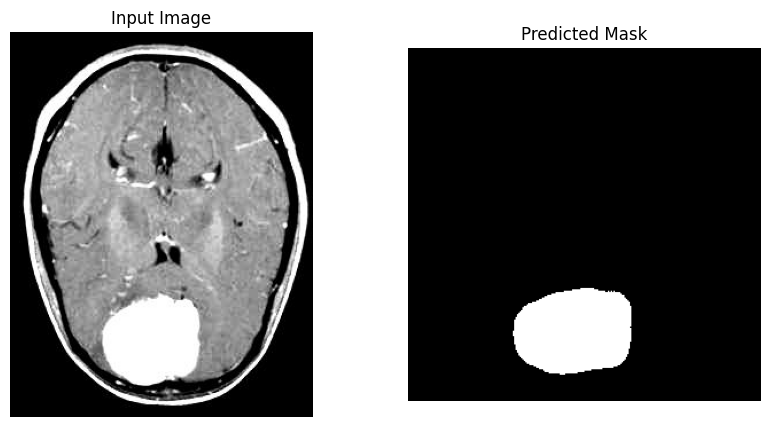

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet().to(device)
# ------------------ Single Image Prediction ---------------------
import matplotlib.pyplot as plt
import numpy as np

# Load trained model weights
model.load_state_dict(torch.load("attention_unet_model.pth", map_location=device))
model.eval()
print("Model loaded for single image prediction ✅")

# Path to the test image (Change this path to your specific image)
TEST_IMAGE_PATH = "/Users/vishwavinayak/Desktop/Deeplearning/brain_tumor/images/y4.jpg"

# Output path to save predicted mask
OUTPUT_MASK_PATH = "predicted_mask.png"

# Transform for test image (same as training)
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image = Image.open(TEST_IMAGE_PATH).convert('L')
input_tensor = test_transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Run inference
with torch.no_grad():
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output)
    pred_mask = (pred_mask > 0.5).float()

# Convert tensor mask to image and save
mask_np = pred_mask.squeeze().cpu().numpy()
mask_np = (mask_np * 255).astype(np.uint8)
mask_img = Image.fromarray(mask_np)
mask_img.save(OUTPUT_MASK_PATH)

print(f"Predicted mask saved as {OUTPUT_MASK_PATH} ✅")

# ------------------ Visualization ---------------------
# Plot input image and predicted mask side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')


plt.show()
